# PFI tests

Three approaches for permutation feature importance:
1. Train-based (multiple trains)
    1. Train a model and record a score (ref score).
    2. Shuffle a feature, re-train, and record score (e.g. val loss).
    3. Iterate on step 2 N times.
    4. For each feature aggregate (mean/median) scores across N runs.
    5. Normalize score of each feature with respect to the reference score.

2. Inference-based using MDA (train once, multiple inferences) __[Azure ML Studio](https://blogs.technet.microsoft.com/machinelearning/2015/04/14/permutation-feature-importance/)__
    1. Train a model and record a score (ref score).
    2. Shuffle a feature, predict, and record score (e.g. val loss).
    3. Iterate on step 2 N times.
    4. For each feature aggregate (mean/median) scores across N runs.
    5. Normalize score of each feature with respect to the reference score.
    
3. Inference-based using prediction spread (train once, multiple inferences)
    1. Train a model.
    2. Shuffle a feature, predict, and score the prediction.
    3. Iterate on step 2 N times.
    4. For each feature compute the spread of predictions across N runs.
    5. The more spread features exhibit, the more important they are.

In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
# utils_path = os.path.abspath('utils_py')
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import rfpimp

import warnings
warnings.filterwarnings("ignore")

SEED=20

/Users/apartin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


## Toy dataset

In [2]:
n_samples = 2000
n_classes = 2
n_features = 10
n_informative = 5
n_redundant = 0
n_repeated = 2
xdata, ydata = make_classification(n_samples = n_samples,
                                   n_classes = n_classes,
                                   n_features = n_features, 
                                   n_informative = n_informative,
                                   n_redundant = n_redundant,
                                   n_repeated = n_repeated,
                                   random_state = SEED, shuffle = False)

ydata = pd.DataFrame(ydata).rename(columns={0: 'y'})
xdata = pd.DataFrame(xdata, columns=[c for c in string.ascii_uppercase[:xdata.shape[1]]])
features = xdata.columns

scaler = StandardScaler()
xdata = scaler.fit_transform(xdata)
xdata = pd.DataFrame(xdata, columns=features)

xtr, xvl, ytr, yvl = train_test_split(xdata, ydata.values.ravel(), test_size=0.2,
                                      random_state=SEED, stratify=ydata)

0 cols out of 10 were dropped based on col variance (th=1e-16).


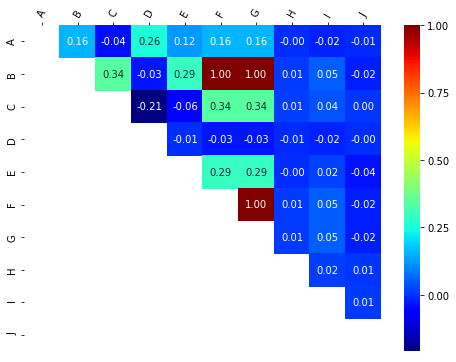

In [3]:
cor = utils.compute_cor_mat(xdata)
utils.plot_cor_heatmap(cor, full=False, figsize=(8, 6));

Explained variance by PCA components [1, 2]:  [0.33780, 0.13121]


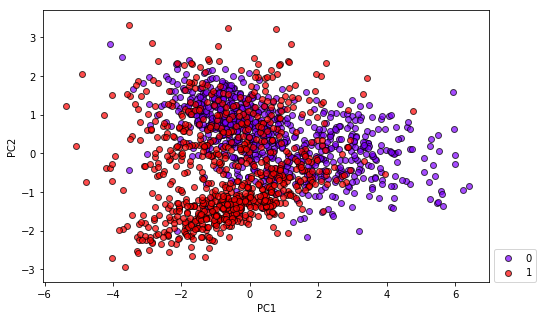

In [4]:
utils.plot_pca(xtr, color_vector=ytr, components=[1, 2], to_scale=True, verbose=True);

## FI using MDI

In [5]:
rf_model = RandomForestClassifier(n_estimators=250, random_state=SEED, oob_score=True)
rf_model.fit(xtr, ytr);
score = rf_model.score(xvl, yvl)
print(score)

0.945


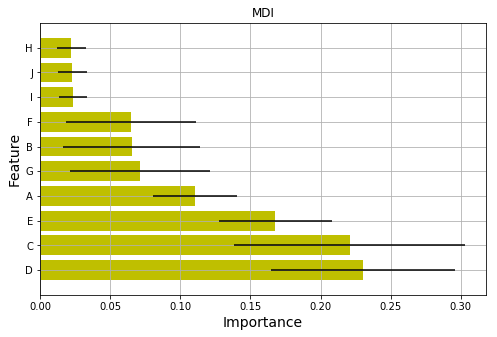

In [6]:
utils.plot_rf_fi(rf_model, columns=xdata.columns, title='MDI');

## FI using MDA

In [7]:
fi = pfi.PFI(model=rf_model, xdata=xvl, ydata=yvl, n_shuffles=20)
fi.compute_pfi(ml_type='c')

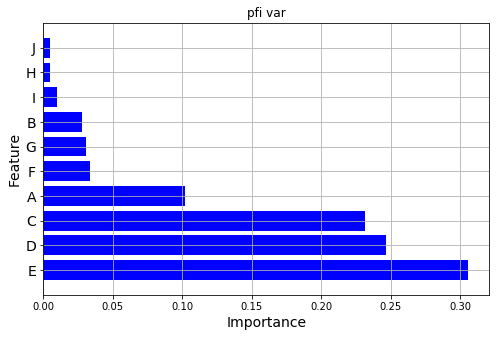

In [8]:
fi.plot_var_fi(title='pfi var');

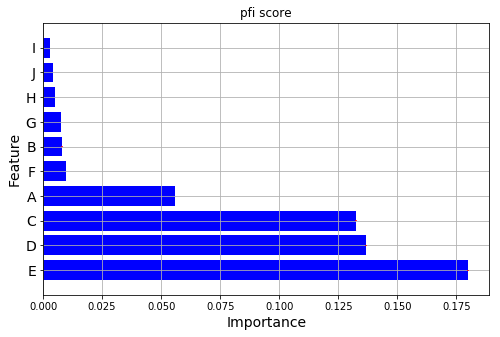

In [9]:
fi.plot_score_fi(title='pfi score');

## FI using MDA (including col_sets)

0 cols out of 10 were dropped based on col variance (th=1e-16).
cor matrix after removing features shape (3, 3)
Time to compute cliques: 0.00 min


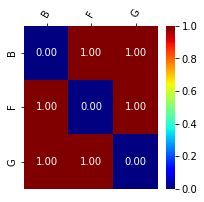

In [10]:
fi = pfi.PFI(model=rf_model, xdata=xvl, ydata=yvl, n_shuffles=20)
fi.gen_col_sets(th=0.9, toplot=True, figsize=(3,3))
fi.compute_pfi(ml_type='c')

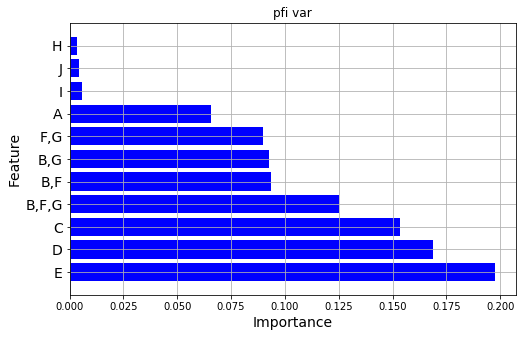

In [11]:
fi.plot_var_fi(title='pfi var');

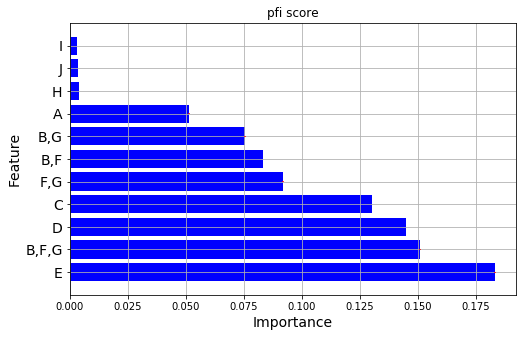

In [12]:
fi.plot_score_fi(title='pfi score');

## rfpimp

CPU times: user 252 ms, sys: 1.58 ms, total: 253 ms
Wall time: 258 ms


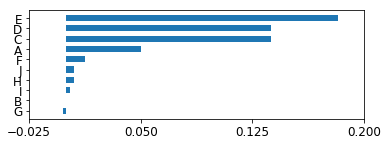

In [13]:
%time I = rfpimp.importances(rf_model, xvl, yvl, n_samples=-1)
rfpimp.plot_importances(I, scalefig=(1,0.5), save=None)

CPU times: user 3.88 s, sys: 19.6 ms, total: 3.9 s
Wall time: 3.91 s


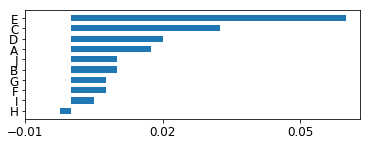

In [14]:
%time I = rfpimp.dropcol_importances(rf_model, xvl, yvl)
rfpimp.plot_importances(I, scalefig=(1, 0.5), save=None)

## Get samples of 2 most representative classes

In [58]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
bincount = df_rna[target_col_name].value_counts(sort=True)
bincount = bincount.reset_index().rename(columns={'index': 'ctype_id', 'ctype_id': 'count'})

In [59]:
bincount[:5]

,ctype_id,count
0,4,1222
1,12,608
2,15,594
3,31,587
4,29,567


In [60]:
# Define sample size per class (take the min size of two classes)
label_size = bincount.loc[:1, 'count'].min()

In [61]:
# Get the smaller class
df1 = df_rna[df_rna[target_col_name] == bincount.loc[1, 'ctype_id']].reset_index(drop=True)
print('df1.shape:', df1.shape)
print(df1['source'].value_counts())

df1.shape: (608, 947)
gdc    608
Name: source, dtype: int64


In [62]:
# Get the larger class
df2 = df_rna[df_rna[target_col_name] == bincount.loc[0, 'ctype_id']].reset_index(drop=True)
print('df2.shape:', df2.shape)
print(df2['source'].value_counts())

df2.shape: (1222, 947)
gdc    1222
Name: source, dtype: int64


In [63]:
# Sample label_size samples from the larger class
df2 = df2.sample(n=label_size, replace=False, axis=0, random_state=SEED).reset_index(drop=True)
print('df2.shape:', df2.shape)
print(df2['source'].value_counts())

df2.shape: (608, 947)
gdc    608
Name: source, dtype: int64


In [64]:
# Concat and shuffle the 2 class datasets
df_rna = pd.concat([df1, df2], axis=0).reset_index(drop=True)
df_rna = df_rna.sample(n=len(df_rna), replace=False, axis=0, random_state=SEED).reset_index(drop=True)
df_rna[:2]

,Sample,source,ctype,ctype_id_name,ctype_id,AARS,ABCB6,ABCC5,ABCF1,ABCF3,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,GDC.BR_BRCA.TCGA_BH_A0B8_00177.n,gdc,Breast Invasive Carcinoma,CTYPE.4,4,5.027,2.422,1.391,4.170,4.766,...,2.473,2.566,1.347,2.110,2.160,3.062,2.080,0.8276,1.1860,2.102
1,GDC.RE_KIRC.TCGA_A3_3311_01869.p,gdc,Kidney Renal Clear Cell Carcinoma,CTYPE.12,12,4.832,2.496,1.757,4.062,4.920,...,2.166,2.314,1.528,2.652,2.412,4.910,2.059,0.8970,0.8496,2.121


In [65]:
print('df_rna.shape:', df_rna.shape)
print(df_rna.ctype.value_counts())

df_rna.shape: (1216, 947)
Kidney Renal Clear Cell Carcinoma    608
Breast Invasive Carcinoma            608
Name: ctype, dtype: int64


Explained variance by PCA components [1, 2]:  [0.41623, 0.10995]


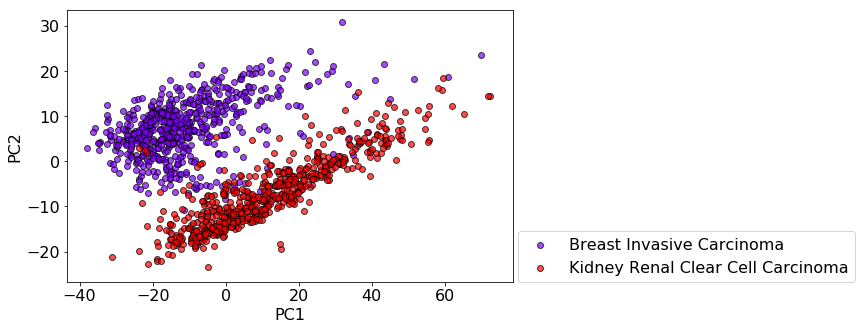

In [66]:
idx = df_rna.columns.get_loc(target_col_name)
plot_pca(df_rna.iloc[:, idx+1:], color_vector=df_rna['ctype'], to_scale=True);

In [67]:
xdata = df_rna.iloc[:, 5:].copy()

## Get subset of features

In [76]:
n_feats = 30
idx = df_rna.columns.get_loc(target_col_name)
tmp = df_rna.iloc[:, idx+1:].sample(n=n_feats, axis=1, random_state=seed)
# df_rna = df_rna.loc[:, df_rna.columns.tolist()[:n_feats]]
tmp = tmp[np.sort(tmp.columns.tolist())]
df_rna = pd.concat([df_rna.iloc[:, :idx+1], tmp], axis=1)
print(df_rna.shape)
print(df_rna.columns)

(1216, 35)
Index(['Sample', 'source', 'ctype', 'ctype_id_name', 'ctype_id', 'ADAM10',
       'ANO10', 'BLVRA', 'CEBPZ', 'CTSD', 'DUSP4', 'ETFB', 'FAH', 'FKBP4',
       'FOXO4', 'FUT1', 'HDAC2', 'HERPUD1', 'KIT', 'LAGE3', 'MEST', 'NFE2L2',
       'NNT', 'NUP93', 'PAK1', 'PECR', 'PLK1', 'PMM2', 'PTPRK', 'RAD9A',
       'RPP38', 'TP53BP1', 'YME1L1', 'ZFP36', 'ZNF451'],
      dtype='object')


## Get feature importance using random forest

In [77]:
df_tr, df_vl = get_dev_data(df_rna, train_split=0.8)
idx = df_rna.columns.get_loc(target_col_name)
xtr = df_tr.iloc[:, idx+1:]
xvl = df_vl.iloc[:, idx+1:]
ytr = df_tr[target_col_name]
yvl = df_vl[target_col_name]

NameError: name 'get_dev_data' is not defined

In [36]:
model = train_forest(xtr, ytr, train_split=0.8, n_estimators=40, max_features=0.5, seed=seed)

In [37]:
fi = rf_feat_importance(model, xtr); fi[:7]

,cols,imp
24,SPP1,0.242887
22,SMARCC1,0.203096
1,COL1A1,0.156399
27,TIMELESS,0.142044
11,KCTD5,0.131414
15,NET1,0.029196
0,CEBPD,0.018196


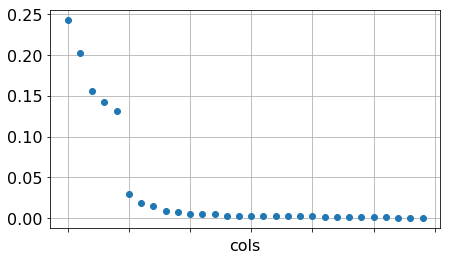

In [38]:
fi.plot(x='cols', y='imp', style='o', figsize=(7,4), legend=False, grid=True);

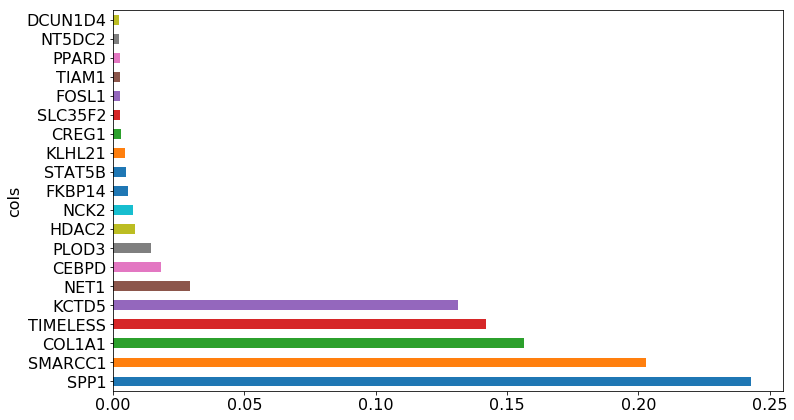

In [39]:
plot_fi(fi[:20]);

In [40]:
yvl_pred = model.predict(xvl)
print('Prediction accuracy: {:.3f}'.format(sum(yvl_pred == yvl)/len(yvl_pred)))

Prediction accuracy: 0.967


### Summarize the most prevalent features

In [43]:
def fi_freq_count(xtr, ytr, n_feats=15, n_runs=10, max_features=0.5):
    """ Compute frequency count of feature importance aggregated over multiple runs.
    Run RF classifier n_runs times and aggregate statistics for the top important features per run.
    """
    tt = pd.DataFrame(index=xtr.columns.sort_values().tolist(), columns=['count', 'count_w'])
    tt = tt.reset_index().rename(columns={'index': 'cols'})
    tt['count'], tt['count_w'] = 0, 0
    
    for r in range(n_runs):
        model = train_forest(xtr, ytr, train_split=0.8, n_estimators=40, max_features=max_features, seed=None)
        fi = rf_feat_importance(model, xtr).reset_index(drop=True)
        for i, f_name in enumerate(fi[:n_feats]['cols']):
            # print('{}: {}'.format(i, f_name))
            tt.loc[tt['cols'] == f_name, 'count'] += 1
            tt.loc[tt['cols'] == f_name, 'count_w'] += n_feats - i
            
    tt['count_w'] /= round(n_feats, 2)
            
    fi_count = tt.sort_values('count_w', ascending=False).reset_index(drop=True)
    return fi_count

In [44]:
fi_count = fi_freq_count(xtr, ytr, n_feats=50, n_runs=10, max_features=0.5)

In [45]:
fi_count['id'] = fi_count['cols'].map(lambda x: fea_dict[x])

In [46]:
# Keep features that counted at least once
fi_count = fi_count[fi_count['count'] > 0]
print(fi_count.shape)
fi_count[:10]

(30, 4)


,cols,count,count_w,id
0,SPP1,10,9.98,787
1,SMARCC1,10,9.74,767
2,KCTD5,10,9.46,421
3,TIMELESS,10,9.46,842
4,COL1A1,10,9.36,176
5,NET1,10,8.92,521
6,CEBPD,10,8.80,144
7,PLOD3,10,8.44,616
8,NCK2,10,8.26,518
9,HDAC2,10,8.26,352
